In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
working_path = '/gpfs/scratch/bsc32/bsc32681/coupled_spinups/tco1279/'
ERA5_path = '/gpfs/scratch/bsc32/bsc32681/eORCA1/ERA5/'
seconds_day = 86400

In [9]:
def load_tco(var,year,period,flux=None):
    if flux:
        vardata = xr.load_dataset(working_path + f'{year}_{var}{period}.nc')[var]
        month_length = vardata.time.dt.days_in_month * seconds_day
        return vardata/month_length
    else:
        return xr.load_dataset(working_path + f'{year}_{var}{period}.nc')['var'][:-1]
        
def annual_mean(data,flux=None):
    #annual mean of monthly data
    month_length = data.time.dt.days_in_month
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    if flux:
        data = data
    vardata = (data*wgts).groupby('time.year').sum('time')
    return vardata

In [10]:
t2m_1950_m = load_tco('2t',1950,'_mon')
t2m_1990_m = load_tco('2t',1990,'_mon')
t2m_1950_y = load_tco('2t',1950,'_year')
t2m_1990_y = load_tco('2t',1990,'_year')

tnr_1950_m = load_tco('tsr',1950,'_mon',flux=True) + load_tco('ttr',1950,'_mon',flux=True)
tnr_1990_m = load_tco('tsr',1990,'_mon',flux=True) + load_tco('ttr',1990,'_mon',flux=True)
tnr_1950_y = annual_mean(tnr_1950_m,flux=True)
tnr_1990_y = annual_mean(tnr_1990_m,flux=True)

CERES = xr.load_dataset(working_path + '../TOA_OBS/CERES_tnr_200003-201410_mean.nc')
ERA5 = xr.load_dataset(ERA5_path + 'tas/gtas_2000-2014.nc')-273.15

ERA5_ymean = annual_mean(ERA5['tas'][2:-2].squeeze())
CERES_ymean = annual_mean(CERES['rt'].squeeze())

ERA5_mean = ERA5['tas'][2:-2].squeeze().mean()
CERES_mean = CERES['rt'].squeeze().mean()


Text(0, 0.5, 'TOA imbalance [Wm$^{-2}$]')

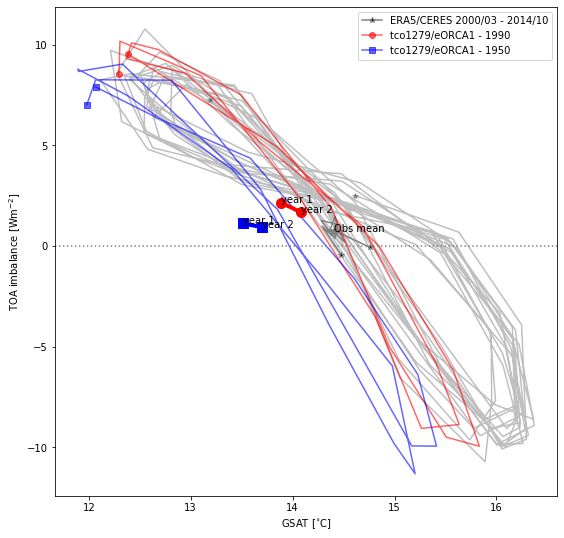

In [11]:
plt.figure(figsize=(9,9))
plt.plot(ERA5['tas'][2:-2].squeeze(),CERES['rt'].squeeze(),'grey',alpha=0.5,markevery=[0,-1], marker='*',markerfacecolor='black')
plt.plot(ERA5_ymean.squeeze(),CERES_ymean.squeeze(),'grey',markevery=[0,-1], marker='*',markerfacecolor='black',label='ERA5/CERES 2000/03 - 2014/10')
plt.plot(t2m_1990_m,tnr_1990_m,'red',markevery=[0,-1], marker='o',label='tco1279/eORCA1 - 1990',alpha = 0.6)
plt.plot(t2m_1950_m,tnr_1950_m,'blue',markevery=[0,-1], marker='s',label='tco1279/eORCA1 - 1950',alpha = 0.6)
plt.plot(t2m_1990_y,tnr_1990_y,'red',markevery=[0,-1], marker='o',lw=4,markersize=10)
plt.plot(t2m_1950_y,tnr_1950_y,'blue',markevery=[0,-1], marker='s',lw=4,markersize=10)
years = [1950,1990]

for i in range(2):
    plt.annotate('year %i'%(i+1),(t2m_1990_y[i],tnr_1990_y[i]))
    plt.annotate('year %i'%(i+1),(t2m_1950_y[i],tnr_1950_y[i]))
    
plt.scatter(ERA5_mean,CERES_mean,marker='*',c='grey',s=100)
plt.annotate('Obs mean',(ERA5_mean,CERES_mean))    
plt.gca().axhline(xmin=0,xmax=1,y=0,color='grey',ls='dotted')
plt.legend()
plt.xlabel('GSAT [$^{\circ}$C]')
plt.ylabel('TOA imbalance [Wm$^{-2}$]')
